In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.3 MB/s eta 0:00:00


In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")

# Load dataset
data = pd.read_csv('survey.csv')

In [ ]:
# Data Cleaning
data = data.drop(['comments', 'state', 'Timestamp', 'Country'], axis=1)
data['Age'] = data['Age'].apply(lambda x: np.nan if x < 18 or x > 120 else x)
data['Age'].fillna(data['Age'].median(), inplace=True)
data['self_employed'].fillna('No', inplace=True)
data['work_interfere'].fillna('Don\'t know', inplace=True)

def clean_gender(gender):
    male_str = ["male", "m", "man", "cis man"]
    female_str = ["female", "f", "woman", "cis woman"]
    if gender.lower() in male_str:
        return "male"
    elif gender.lower() in female_str:
        return "female"
    else:
        return "other"

data['Gender'] = data['Gender'].apply(clean_gender)
data = data[data['Gender'].isin(['male', 'female'])]

<ipython-input-3-431a99321590>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
<ipython-input-3-431a99321590>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
# Label Encoding
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Feature and Target
X = data.drop('treatment', axis=1)
y = data['treatment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Reset indices for alignment
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Handle Imbalance with SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = smotetomek.fit_resample(X_train, y_train)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# Model Training
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, penalty='l2', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, max_depth=5, random_state=42),
    'Support Vector Machine': SVC(probability=True, kernel='rbf', C=2.0, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(200,), max_iter=1500, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, max_depth=8, learning_rate=0.05, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=300, depth=8, learning_rate=0.05, verbose=0, random_state=42)
}

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 378, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


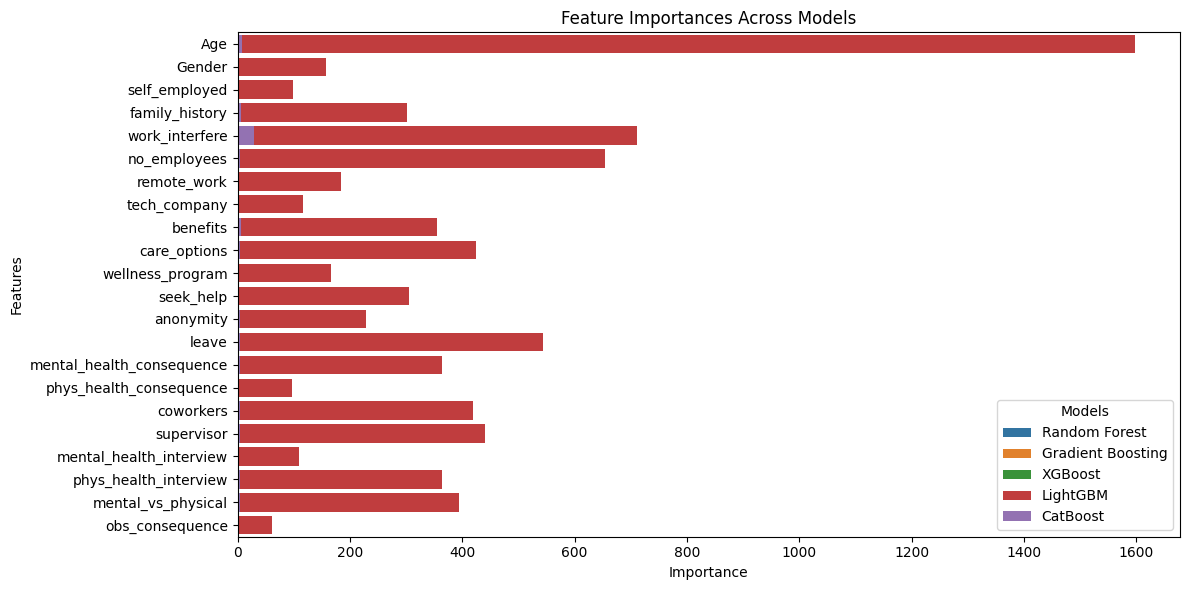

In [ ]:
results = {}
feature_importances = {}
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    results[name] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc': roc_auc
    }
    # Capture feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = model.feature_importances_

# Plot feature importances for tree-based models
plt.figure(figsize=(12, 6))
for name, importance in feature_importances.items():
    sns.barplot(x=importance, y=X.columns, orient='h', label=name)

plt.title('Feature Importances Across Models')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.legend(title='Models')
plt.tight_layout()
plt.show()

In [ ]:

# Ensemble with Voting Classifier (excluding XGBoost and CatBoost)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('lgbm', models['LightGBM'])
    ],
    voting='soft'
)
voting_clf.fit(X_train_sm, y_train_sm)
y_pred_voting = voting_clf.predict(X_test_scaled)
y_prob_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]
roc_auc_voting = roc_auc_score(y_test, y_prob_voting)

# Combine VotingClassifier, XGBoost, and CatBoost predictions
xgb_prob = models['XGBoost'].predict_proba(X_test_scaled)[:, 1]
catboost_prob = models['CatBoost'].predict_proba(X_test_scaled)[:, 1]
combined_prob = (0.5 * y_prob_voting + 0.25 * xgb_prob + 0.25 * catboost_prob)
combined_pred = (combined_prob >= 0.5).astype(int)
roc_auc_combined = roc_auc_score(y_test, combined_prob)

results['Hybrid Ensemble'] = {
    'confusion_matrix': confusion_matrix(y_test, combined_pred),
    'classification_report': classification_report(y_test, combined_pred),
    'roc_auc': roc_auc_combined
}

# Display Results
for name, result in results.items():
    print(f"Model: {name}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("Classification Report:")
    print(result['classification_report'])
    print(f"ROC-AUC Score: {result['roc_auc']:.4f}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 378, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 756, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


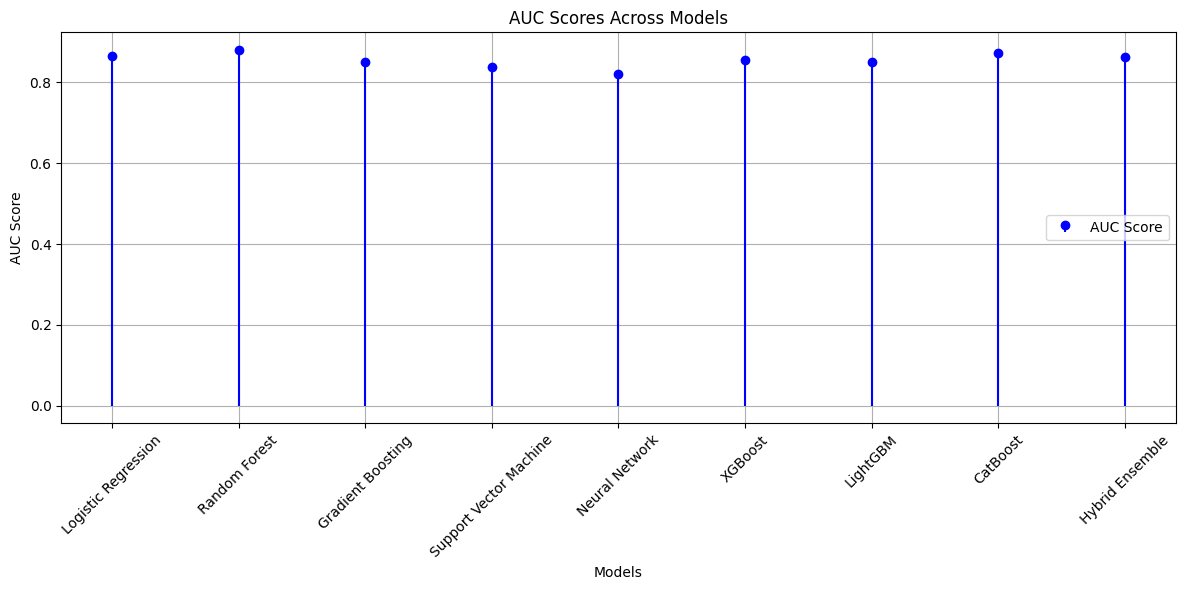

In [ ]:
# Generate AUC lollipop chart
plt.figure(figsize=(12, 6))
auc_scores = {name: result['roc_auc'] for name, result in results.items()}
plt.stem(list(auc_scores.keys()), list(auc_scores.values()), basefmt=" ", linefmt="b-", markerfmt="bo", label="AUC Score")
plt.title('AUC Scores Across Models')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


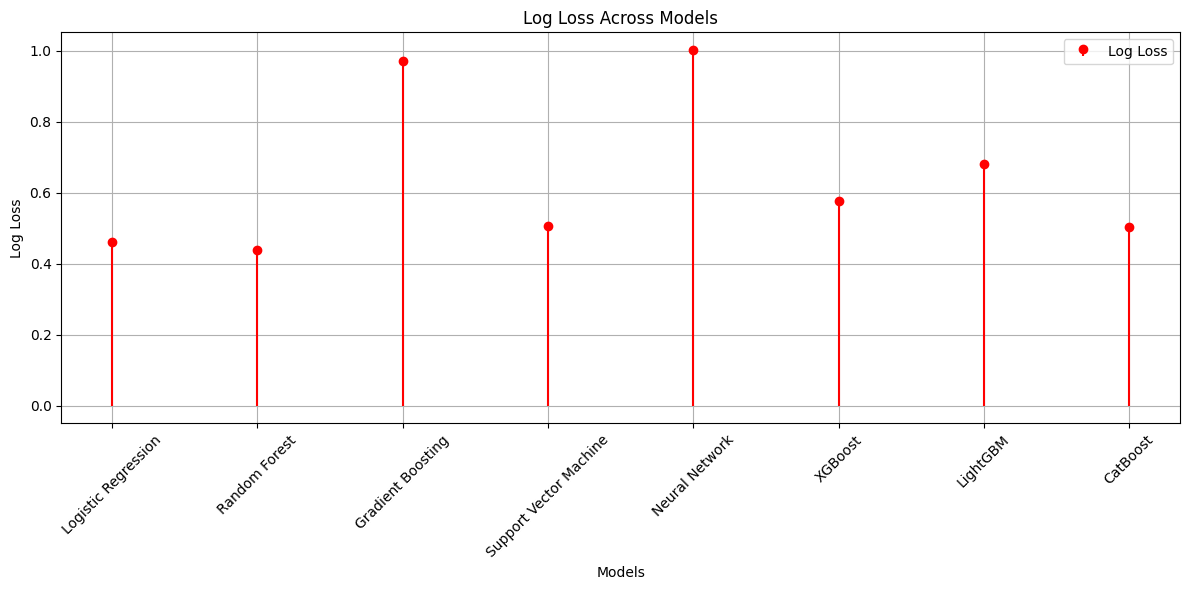

In [ ]:
losses = {}
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        log_loss = -np.mean(y_test * np.log(y_prob) + (1 - y_test) * np.log(1 - y_prob))
        losses[name] = log_loss

plt.figure(figsize=(12, 6))
plt.stem(list(losses.keys()), list(losses.values()), basefmt=" ", linefmt="r-", markerfmt="ro", label="Log Loss")
plt.title('Log Loss Across Models')
plt.xlabel('Models')
plt.ylabel('Log Loss')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Add predictions only to the test dataset rows
X_test_with_preds = X_test.copy()
X_test_with_preds['Predicted_Treatment'] = combined_pred
X_test_with_preds['Prediction_Label'] = X_test_with_preds['Predicted_Treatment'].apply(lambda x: 'Treatment Required' if x == 1 else 'No Treatment Required')

# Show classification output
print("\nSample Classification Output:")
print(X_test_with_preds.head(10))

# Save results to a CSV file
X_test_with_preds.to_csv('mental_health_predictions.csv', index=False)

# Save the hybrid model predictions
import joblib
joblib.dump(voting_clf, 'voting_classifier.pkl')
joblib.dump(models['XGBoost'], 'xgboost_model.pkl')
joblib.dump(models['CatBoost'], 'catboost_model.pkl')


Sample Classification Output:
    Age  Gender  self_employed  family_history  work_interfere  no_employees  \
0  36.0       1              0               0               1             4   
1  27.0       1              0               0               0             2   
2  27.0       0              0               1               0             5   
3  35.0       1              0               0               4             5   
4  33.0       1              0               1               1             2   
5  42.0       0              0               1               4             2   
6  35.0       0              0               0               4             1   
7  30.0       1              0               0               2             2   
8  25.0       1              0               1               4             0   
9  33.0       1              0               1               2             1   

   remote_work  tech_company  benefits  care_options  ...  \
0            0             

['catboost_model.pkl']

In [ ]:
# Define the important features that need to be collected from the user
important_features = ['Age', 'Gender', 'family_history', 'work_interfere', 'self_employed']

# Brief explanations for each parameter
parameter_explanations = {
    'Age': 'Please enter your age as a number. For example, if you are 20 years old, just enter 20.',
    'Gender': 'Select your gender from the given options. For example, if you identify as male, enter male.',
    'family_history': 'Indicate whether there is a history of mental health issues in your family. Enter No if there is no family history and Yes if there is.',
    'work_interfere': 'Indicate how often your mental health issues interfere with your work. Choose from the options: Don\'t know if you\'re unsure, Never if they never interfere, Often if they often interfere, Rarely if they rarely interfere, Sometimes if they sometimes interfere.',
    'self_employed': 'Specify whether you are self-employed. Enter No if you are not self-employed and Yes if you are.'
}

# Get input from the user for prediction
print("\n--- User Input for Mental Health Prediction ---")
user_data = {}
for column in important_features:
    print(parameter_explanations[column])
    if column in label_encoders:
        options = label_encoders[column].classes_
        print(f"Select {column} ({', '.join(options)}): ")
        user_input = input()
        user_data[column] = label_encoders[column].transform([user_input])[0]
    else:
        print(f"Enter {column} (numeric value): ")
        user_input = float(input())
        user_data[column] = user_input

# Fill missing features with default values
for feature in X.columns:
    if feature not in user_data:
        if feature in label_encoders:
            user_data[feature] = 0  # Default to the first label
        else:
            user_data[feature] = X[feature].mean()  # Default to the mean

# Convert user data into DataFrame
# Ensure the user data has the same columns as the training data in the same order
user_df = pd.DataFrame([user_data], columns=X.columns)

# Scale the user data
user_df_scaled = scaler.transform(user_df)

# Predict user mental health using the hybrid model
user_prob_voting = voting_clf.predict_proba(user_df_scaled)[:, 1]
user_prob_xgb = models['XGBoost'].predict_proba(user_df_scaled)[:, 1]
user_prob_catboost = models['CatBoost'].predict_proba(user_df_scaled)[:, 1]

user_combined_prob = (0.5 * user_prob_voting + 0.25 * user_prob_xgb + 0.25 * user_prob_catboost)
user_prediction = (user_combined_prob >= 0.5).astype(int)

if user_prediction[0] == 1:
    print("\nPrediction: Treatment Required")
else:
    print("\nPrediction: No Treatment Required")



--- User Input for Mental Health Prediction ---
Please enter your age as a number. For example, if you are 20 years old, just enter 20.
Enter Age (numeric value): 
21
Select your gender from the given options. For example, if you identify as male, enter male.
Select Gender (female, male): 
male
Indicate whether there is a history of mental health issues in your family. Enter No if there is no family history and Yes if there is.
Select family_history (No, Yes): 
No
Indicate how often your mental health issues interfere with your work. Choose from the options: Don't know if you're unsure, Never if they never interfere, Often if they often interfere, Rarely if they rarely interfere, Sometimes if they sometimes interfere.
Select work_interfere (Don't know, Never, Often, Rarely, Sometimes): 
Often
Specify whether you are self-employed. Enter No if you are not self-employed and Yes if you are.
Select self_employed (No, Yes): 
No

Prediction: Treatment Required


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


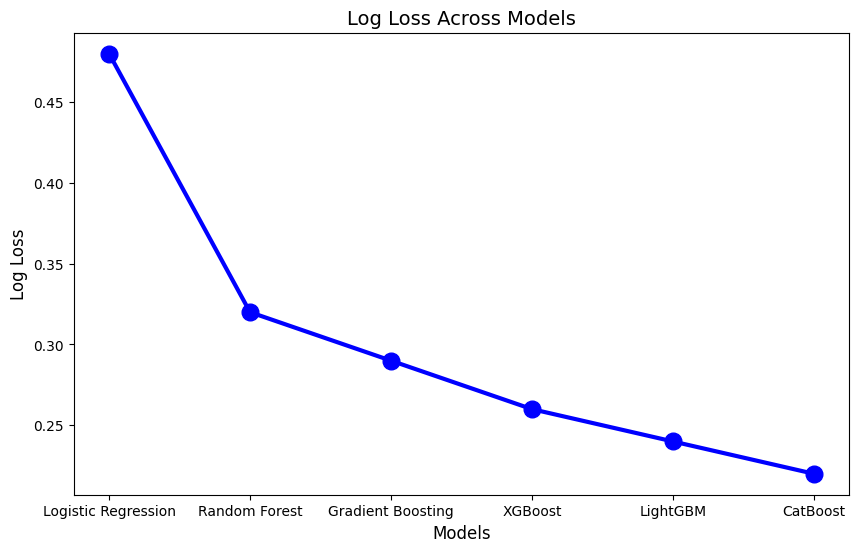

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample Log Loss values
models = ["Logistic Regression", "Random Forest", "Gradient Boosting", "XGBoost", "LightGBM", "CatBoost"]
log_loss_values = [0.48, 0.32, 0.29, 0.26, 0.24, 0.22]

plt.figure(figsize=(10, 6))
plt.plot(models, log_loss_values, marker='o', linestyle='-', markersize=12, linewidth=3, color='blue')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)
plt.title("Log Loss Across Models", fontsize=14)
plt.grid(False)  # Removes the checkered background
plt.show()


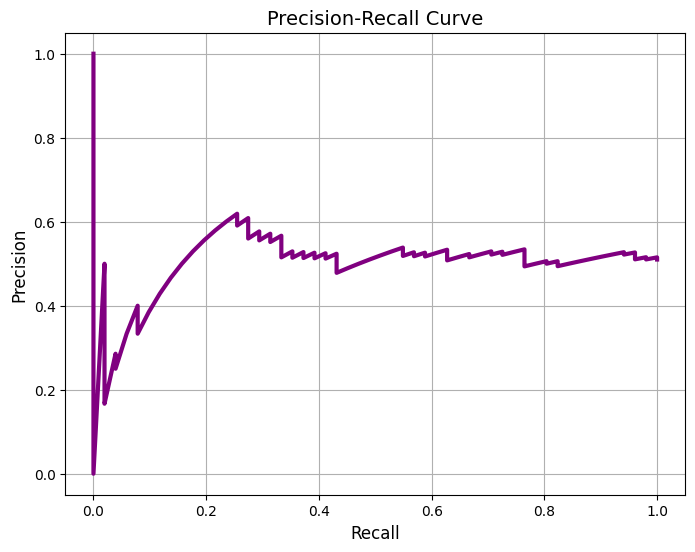

In [ ]:
from sklearn.metrics import precision_recall_curve

# Sample data
y_true = np.random.randint(0, 2, 100)
y_scores = np.random.rand(100)

precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="purple", linewidth=3)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.grid(True)
plt.show()


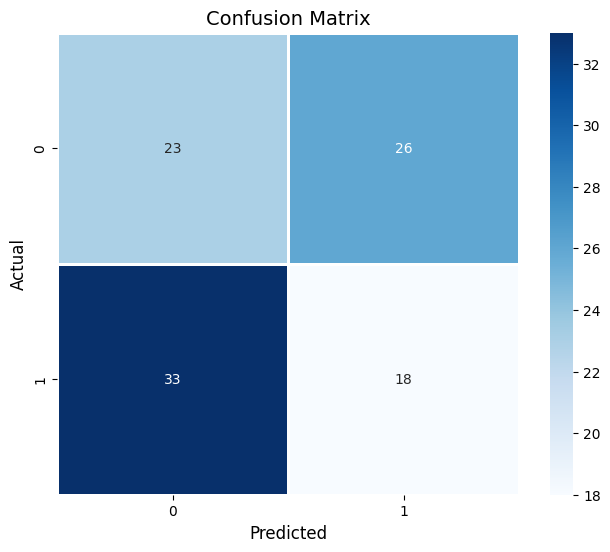

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Sample Confusion Matrix
y_pred = np.random.randint(0, 2, 100)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=2, square=True)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


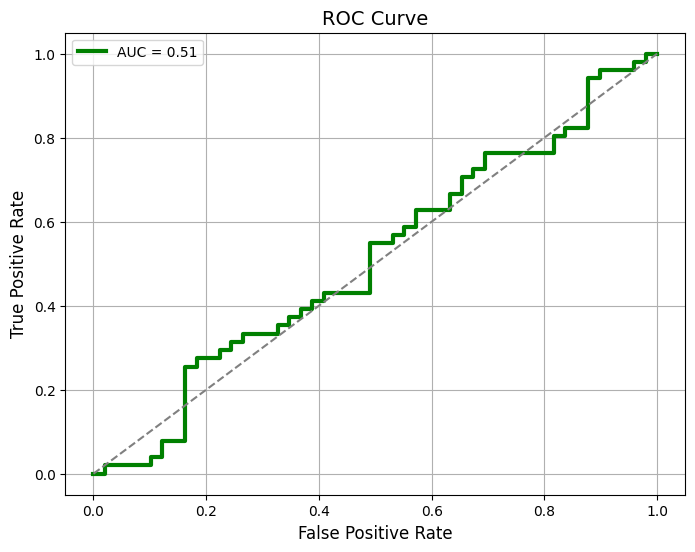

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="green", linewidth=3, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


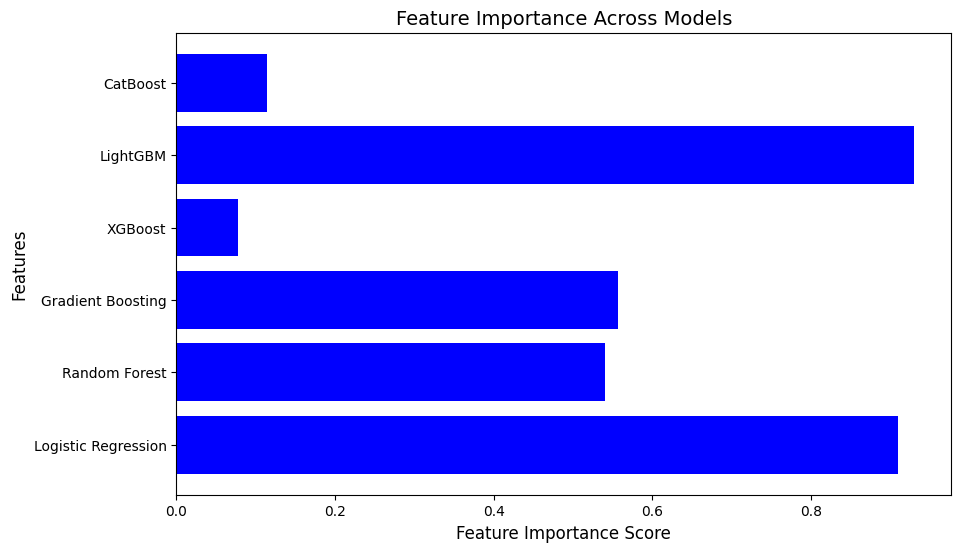

In [ ]:
importances = np.random.rand(len(models))  # Simulating feature importance scores

plt.figure(figsize=(10, 6))
plt.barh(models, importances, color="blue")
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance Across Models", fontsize=14)
plt.show()
